# Installs

In [21]:
# !pip install --upgrade pip # To support manylinux2010 wheels.
# !pip install --upgrade flax

In [12]:
!pip install wandb


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [13]:
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install jax[cuda12_pip]==0.4.21 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Imports

In [14]:
def inverse_grid_number(n, number):
    if 1 <= number <= n**2:
        row_index = (number - 1) // n + 1
        column_index = (number - 1) % n + 1
        return row_index, column_index
    else:
        raise ValueError("Number must be between 1 and n^2 inclusive.")

def grid_number(n, a, b):
    if 1 <= a <= n and 1 <= b <= n:
        return (a - 1) * n + b
    else:
        raise ValueError("Row and column indices must be between 1 and n inclusive.")

def reflection_grid(n, coordinates):
    a, b = coordinates
    reflected_b = n - b + 1
    return a, reflected_b

def rotation_grid(n, coordinates):
    a, b = coordinates
    rotated_a = n - b + 1
    rotated_b = a
    return rotated_a, rotated_b

def rotate(n, number):
    (a,b) = inverse_grid_number(n, number)
    (new_a, new_b) = rotation_grid(n, (a,b))
    return grid_number(n, new_a, new_b)

def reflect(n, number):
    (a,b) = inverse_grid_number(n, number)
    (new_a, new_b) = reflection_grid(n, (a,b))
    return grid_number(n, new_a, new_b)

def generate_rotation_matrix(n):
    # Define the size of the matrix
    matrix_size = n ** 2

    # Initialize a matrix with zeros
    rotation_matrix = sp.zeros(matrix_size, matrix_size)

    # Set 1 at the specified positions for each column
    for m in range(1, matrix_size + 1):
        rotated_position = rotate(n, m)
        rotation_matrix[rotated_position - 1, m - 1] = 1  # Adjust for 0-based indexing

    return rotation_matrix

def generate_reflection_matrix(n):
    # Define the size of the matrix
    matrix_size = n ** 2

    # Initialize a matrix with zeros
    reflection_matrix = sp.zeros(matrix_size, matrix_size)

    # Set 1 at the specified positions for each column
    for m in range(1, matrix_size + 1):
        reflected_position = reflect(n, m)
        reflection_matrix[reflected_position - 1, m - 1] = 1  # Adjust for 0-based indexing

    return reflection_matrix

def generate_d4_matrices_sp(n):
    '''Outputs n^2 by n^2 matrices'''
    # Get rotation and reflection matrices
    R = generate_rotation_matrix(n)
    S = generate_reflection_matrix(n)

    # Calculate R^2, R^3, SR, SR^2, SR^3
    R2 = R@R
    R3 = R2@R
    SR = S@R
    SR2 = S@R2
    SR3 = S@R3

    # Generate D4 matrices
    D4_matrices = [sp.eye(n**2), R, R2, R3, S, SR, SR2, SR3]

    return D4_matrices



In [15]:
from flax import linen as nn


In [16]:
## Standard libraries
import os
import numpy as np
from typing import Sequence
import shutil
from functools import partial
import math
import scipy as scipy
import itertools

### JAX
import jax
import jax.numpy as jnp

### Flax
from flax import linen as nn
from flax.training import train_state
from flax.core.frozen_dict import freeze, unfreeze

### Optax
import optax

### Logging and plotting
import wandb
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from IPython.display import set_matplotlib_formats
from PIL import Image

print(f"The jax default backend is: {jax.default_backend()}")

## PyTorch libraries
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
# import torch.nn as nn

## Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

import wandb

The jax default backend is: cpu


# MNIST + Bx

In [17]:
from sympy.parsing.sympy_parser import parse_expr

with open('8x8COB.txt', 'r') as f:
    Q = [next(f) for _ in range(129)] # f.read()
Q = [parse_expr(s.strip('\n')) for s in Q if s != '\n']
Q = Q[1:] # Remove constant
Q1, Q2, Q3, Q4, Q56, Q78 = Q[:10], Q[10:16], Q[16:22], Q[22:32], Q[32:48], Q[48:]
Q1, Q2, Q3, Q4, Q56, Q78 = [elem[0,0] for elem in Q1], [elem[1,0] for elem in Q2], [elem[2,0] for elem in Q3], [elem[3,0] for elem in Q4], [elem[(4,5),0].tolist() for elem in Q56], [elem[(6,7),0].tolist() for elem in Q78]

In [18]:
import re
Q1_Str = [[elem.replace('x','') for elem in l] for l in [str(q).split(' + ') for q in Q1]]
Q2_str = [str(q).replace(' - ',' + -') for q in Q2]
Q2_Str = [[elem.replace('x','') for elem in l] for l in [str(q).split(' + ') for q in Q2_str]]
Q3_str = [str(q).replace(' - ',' + -') for q in Q3]
Q3_Str = [[elem.replace('x','') for elem in l] for l in [str(q).split(' + ') for q in Q3_str]]
Q4_str = [str(q).replace(' - ',' + -') for q in Q4]
Q4_Str = [[elem.replace('x','') for elem in l] for l in [str(q).split(' + ') for q in Q4_str]]
Q56_str = [(str(q[0]).replace(' - ',' + -'),str(q[1]).replace(' - ',' + -')) for q in Q56]
Q56_Str = [[[elem.replace('x','').replace('[','').replace(']','') for elem in l0],[elem.replace('x','').replace('[','').replace(']','') for elem in l1]] for l0,l1 in [(q[0].split(' + '),q[1].split(' + ')) for q in Q56_str]]

In [19]:
from math import copysign

X_matrix = jnp.zeros((64,64))

Q1_to_4 = Q1_Str + Q2_Str + Q3_Str + Q4_Str

for i in range(32):
  for elem in Q1_to_4[i]:
    X_matrix = X_matrix.at[i,abs(int(elem))-1].set(np.sign(int(elem))*1)

for i in range(16):
  for elem in Q56_Str[i][0]:
    X_matrix = X_matrix.at[i+32,abs(int(elem))-1].set(np.sign(int(elem))*1)
  for elem in Q56_Str[i][1]:
    X_matrix = X_matrix.at[i+48,abs(int(elem))-1].set(np.sign(int(elem))*1)

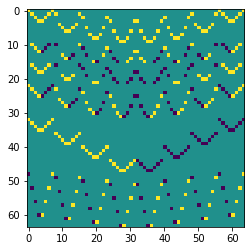

In [20]:
B = X_matrix.copy()
plt.imshow(B)

# Rotate 8x8 as 64 vec image

In [17]:
def inverse_grid_number(n, number):
    if 1 <= number <= n**2:
        row_index = (number - 1) // n + 1
        column_index = (number - 1) % n + 1
        return row_index, column_index
    else:
        raise ValueError("Number must be between 1 and n^2 inclusive.")

def grid_number(n, a, b):
    if 1 <= a <= n and 1 <= b <= n:
        return (a - 1) * n + b
    else:
        raise ValueError("Row and column indices must be between 1 and n inclusive.")

def reflection_grid(n, coordinates):
    a, b = coordinates
    reflected_b = n - b + 1
    return a, reflected_b

def rotation_grid(n, coordinates):
    a, b = coordinates
    rotated_a = n - b + 1
    rotated_b = a
    return rotated_a, rotated_b

def rotate(n, number):
    (a,b) = inverse_grid_number(n, number)
    (new_a, new_b) = rotation_grid(n, (a,b))
    return grid_number(n, new_a, new_b)

def reflect(n, number):
    (a,b) = inverse_grid_number(n, number)
    (new_a, new_b) = reflection_grid(n, (a,b))
    return grid_number(n, new_a, new_b)

def generate_rotation_matrix(n):
    # Define the size of the matrix
    matrix_size = n ** 2

    # Initialize a matrix with zeros
    rotation_matrix = jnp.zeros((matrix_size, matrix_size), dtype=int)

    # Set 1 at the specified positions for each column
    for m in range(1, matrix_size + 1):
        rotated_position = rotate(n, m)
        rotation_matrix = rotation_matrix.at[rotated_position - 1, m - 1].set(1)  # Adjust for 0-based indexing

    return rotation_matrix

def generate_reflection_matrix(n):
    # Define the size of the matrix
    matrix_size = n ** 2

    # Initialize a matrix with zeros
    reflection_matrix = jnp.zeros((matrix_size, matrix_size), dtype=int)

    # Set 1 at the specified positions for each column
    for m in range(1, matrix_size + 1):
        reflected_position = reflect(n, m)
        reflection_matrix = reflection_matrix.at[reflected_position - 1, m - 1].set(1)  # Adjust for 0-based indexing

    return reflection_matrix

def generate_d4_matrices(n):
    '''Outputs n^2 by n^2 matrices'''
    # Get rotation and reflection matrices
    R = generate_rotation_matrix(n)
    S = generate_reflection_matrix(n)

    # Calculate R^2, R^3, SR, SR^2, SR^3
    R2 = jnp.dot(R, R)
    R3 = jnp.dot(R2, R)
    SR = jnp.dot(S, R)
    SR2 = jnp.dot(S, R2)
    SR3 = jnp.dot(S, R3)

    # Generate D4 matrices
    D4_matrices = [jnp.eye(n**2), R, R2, R3, S, SR, SR2, SR3]

    return D4_matrices



In [18]:
class RotMNISTDataset(torch.utils.data.Dataset):

    def __init__(self, torch_images, torch_labels, classes):

        torch_ids = torch.argwhere(torch.tensor([label in classes for label in torch_labels]))
        self.original_points = len(torch_ids)
        self.points = self.original_points*4

        self.labels = torch.concat([torch_labels[torch_ids] for i in range(4)], axis=-1).reshape((self.points,))

        self.ids = torch.tensor(np.array([i for i in range(self.points)]))

        images = torch_images[torch_ids].reshape((self.original_points,64))
        args = jax.random.randint(jax.random.PRNGKey(42),(self.original_points,4),0,8)
        matrices = jnp.array(generate_d4_matrices(28))

        def apply_matrix(img, D4matrix):
            return jnp.stack([matrices[i] @ img for i in range(4)])
        apply_matrices = jax.vmap(apply_matrix,(0, 0), 0)

        all_images = apply_matrices(jnp.array(images),args).reshape((self.points,64))
        self.all_images = torch.from_numpy(np.array(all_images))
        self.all_Xs = torch.from_numpy(np.array(all_images @ B.T))

    def __len__(self):
        return self.points

    def __getitem__(self, index):
        image, label, X = self.all_images[index], self.labels[index], self.all_Xs[index]
        return (image, label, X)

In [19]:
def numpy_collate(batch):
  n = len(batch)
  imgs = jnp.stack([jnp.array(batch[i][0]) for i in range(n)])
  labels = jnp.array([batch[i][1] for i in range(n)])
  Xs = jnp.stack([jnp.array(batch[i][3]) for i in range(n)])
  return [imgs, labels, Xs]

In [20]:
data_dir = './data'
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_ds = torchvision.datasets.MNIST(root=data_dir,
                                                train=True,
                                                transform=transform,
                                                download=True)

In [21]:
classes = [torch.tensor(i) for i in range(3)]
train_ds = RotMNISTDataset(train_ds.data[:,:,:]/256, train_ds.targets[:], classes)
print("Total no. of points:", len(train_ds))

train_ds, val_ds = torch.utils.data.random_split(train_ds, [int(9*len(train_ds)/11), int(2*len(train_ds)/11)])
batch_size = 64
points = len(train_ds)
print("Points in training:", points)
# print("Points in validation:", len(val_ds))

train_loader = torch.utils.data.DataLoader(train_ds, collate_fn=numpy_collate, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_ds, collate_fn=numpy_collate, batch_size=len(val_ds), shuffle=True)

RuntimeError: shape '[18623, 64]' is invalid for input of size 14600432

# General Dataset

In [ ]:

train_ds = torch.utils.data.Dataset()
val_ds = torch.utils.data.Dataset()

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, collate_fn=numpy_collate)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=100000, collate_fn=numpy_collate)

In [ ]:
|# FOR VIBA

# irreps = {}
# reps =

# def get_dim_alpha_eigenvalues(irreps):
#   di = {}
#   for n in range():
#     di[n] = {}
#     for k in range(irreps.keys()): # different k for dimension of irreps
#       di[n][k] = {}
#       for j in range(len(irreps[k])): # no. of kD irreps
#         e, P = np.linalg.eig(np.array([[irreps[n][k][j]]],dtype=np.float64))
#         e = e.astype(np.complex64)
#         e = np.around(e).astype(np.complex64)
#         unique, _ = np.unique(e, return_counts=True)
#         di[n][k][j] = unique.astype(np.complex64)
#   return di

# def get_B_jax(representations):
#   d = {}
#   for n in range(8):
#     # Get eigenvalues and eigenvectors of representations
#     e, P = np.linalg.eig(np.array(representations[n],dtype=np.float64))
#     e_copy = e
#     e = e.astype(np.complex64)
#     e = np.around(e).astype(np.complex64)

#     # Count eigenvalues and sort as well as eigenvectors
#     unique, counts = np.unique(e, return_counts=True)
#     d[n] = (unique.astype(np.complex64), counts)

# for n in range(0,order):
#   for elem,count in zip(*d[n]):
#     print('n',parse_expr('+'.join(['s'+str(k+1) for k in di[n].keys() if np.any(di[n][k] == elem)])))

# # Solve equations to find m_alphas
# m_alphas = []

# def get_B(m_alphas):



In [ ]:
def numpy_collate(batch):
  n = len(batch)
  x = [jnp.array(batch[i][0]) for i in range(n)]
  labels = jnp.array([batch[i][1] for i in range(n)])
  x_reg_rep = x @ B_jax.T
  return [labels, x_reg_rep]

def torch_collate(batch):
  n = len(batch)
  x, labels = batch
  x_reg_rep = x @ B_torch.T
  return [labels, x_reg_rep]

# General model

In [ ]:
# Insert fundamental invariants here
Pi_vmap = jax.vmap(lambda x: jnp.array( [x[0],x[1]**2,x[2]**2,x[3]**2,x[4]**2+x[5]**2,x[6]**2+x[7]**2,x[4]**4+x[5]**4,x[6]**4+x[7]**4] ), 0, 0)

In [ ]:
class Pi(nn.Module):

    # Calculate pi(.)=(pi_1(.),...,pi_r(.)) for inputs in R^d_reg_rep


    @nn.compact
    def __call__(self, input):

       shpe = input.shape # (batch_size, T_size, d_reg_rep)
       x = input.reshape((-1, shpe[-1])) # (batch_size*T_size, d_reg_rep)
       pi = Pi_vmap(x) # (batch_size*T_size, n_invs)

       return  pi.reshape(tuple([*shpe[:-1]]+[pi.shape[-1]])) #(batch_size, T_size, n_invs)

In [ ]:
class A_alpha(nn.Module):

    # Each A_alpha is (m_alpha,dim_alpha) matrix and
    # takes R^dim_alpha*m_alpha to R^dim_alpha**2
    # for all t=1,...,T_size

    T_size: int
    m_alpha: int
    dim_alpha: int

    def setup(self):

      self.W = self.param('W', nn.initializers.glorot_normal(), (self.T_size,self.m_alpha,self.dim_alpha))

    def __call__(self, input): # (batch_size, m_alpha*dim_alpha)

      Ax = input.reshape((-1,1,self.dim_alpha,self.m_alpha)) @  self.W

      return Ax.reshape((-1,self.T_size,self.dim_alpha**2), order='F') # (batch_size, T_size, dim_alpha**2)

In [ ]:
class ALayers(nn.Module):

    # Maps x in R^d_data=sum(dim_alpha*m_alpha for alpha) to R^d_reg_rep=sum(dim_alpha**2 for alpha)
    # for all t=1,...,T_size

    T_size: int
    m_alphas: Sequence[int]
    dim_alphas: Sequence[int]

    def setup(self):

      self.A_alphas = [A_alpha(self.T_size, self.m_alphas[i], self.dim_alphas[i]) for i in range(len(self.dim_alphas))]
      self.splits = [0,int(self.m_alphas[0])]+[int(self.m_alphas[i]*self.dim_alphas[i]+sum(self.m_alphas[:i])) for i in range(1,len(self.m_alphas))]

    def __call__(self, input): # (batch_size, d_data)

       vl = [self.A_alphas[i](input[:,:,self.splits[i]:self.splits[i+1]]) for i in range(len(self.splits)-1)]

       return  jnp.concatenate(vl, axis=-1) #(batch_size, T_size, d_reg_rep)

In [ ]:
class ParallelDense(nn.Module):

    # Dense layer W_lt+b_lt to approximate layer l of f_t(.)
    # for all t=1,...,T_size

    features_in: int
    features_out: int
    T_size: int

    def setup(self):
       self.W = self.param('W', nn.initializers.glorot_normal(), (self.T_size, self.features_in, self.features_out))
       self.b = self.param('b', nn.initializers.glorot_normal(), (self.T_size, self.features_out))

    def __call__(self, input): # (batch_size, T_size, features_in)

       return (jnp.expand_dims(input, axis=-2) @ self.W).squeeze() + self.b.squeeze() # (batch_size, T_size, features_out)

In [ ]:
class ParallelPoly(nn.Module):

    # Approximate T polynomials f_t(.) map R^n_invs
    # to R^n_classes for all t=1,...,T_size

    T_size: int
    p_layers : Sequence[int]
    n_classes: int

    @nn.compact
    def __call__(self, input): # (batch_size, T_size, n_invs)
       input = jnp.expand_dims(input, axis = -2) # (batch_size, T_size, 1, n_invs)

       v = ParallelDense(input.shape[-1], self.p_layers[0], self.T_size)(input)
       v = nn.gelu(v)

       for i in range(len(self.p_layers)-1):
          v = ParallelDense(self.p_layers[i], self.p_layers[i+1], self.T_size)(v)
          v = nn.gelu(v)

       v = ParallelDense(self.p_layers[-1], self.n_classes, self.T_size)(v)

       return v # (batch_size, T_size, n_classes)

In [ ]:
class InvModel(nn.Module):


    T_size : int
    m_alphas : Sequence[int]
    dim_alphas: Sequence[int]
    p_layers: Sequence[int]
    n_classes: int

    def setup(self):

       self.c_ts = self.param('c_ts', nn.initializers.normal(), (self.T_size,1))

       self.A_ts = ALayers(self.T_size,self.m_alphas, self.dim_alphas)

       self.pi = Pi()

       self.f_ts = ParallelPoly(self.T_size,3*self.s,self.p_layers)


    def __call__(self, input): # (batch_size, d_data)

       label, x_reg_rep = input

       At = self.A_ts(x_reg_rep) # (batch_size, T_size, d_reg_rep)

       PiAt = self.pi(At) # (batch_size, T_size, n_invs)

       ft = self.f_ts(PiAt) # (batch_size, T_size, n_classes)

       output = jnp.sum(ft * self.c_ts, axis=1) #(batch_size, n_classes)

       return output, label

# Train

In [ ]:
from flax.core.frozen_dict import freeze, unfreeze
from flax.core.frozen_dict import pop as flax_pop
import math

class TrainerModule:

    def __init__(self, model_name,
                      train_loader, # Train dataset loader
                      val_loader,
                      lr=1e-5, # Learning rate
                      seed=42,
                      wandb_log=False,
                      T_size=5,
                      m_alphas=[105,91,91,105,196],
                      dim_alphas=[1,1,1,1,2],
                      p_layers=[32,64,32,16],
                      n_classes=10):


        super().__init__()

        # Trainer inputs
        self.model_name = model_name
        self.train_loader=train_loader
        self.val_loader=val_loader
        self.lr = lr
        self.seed = seed
        self.wandb_log=wandb_log

        # Model inputs for InvModel and EquiModel
        self.T_size=T_size
        self.m_alphas=m_alphas
        self.dim_alphas=dim_alphas
        self.p_layers=p_layers
        self.n_classes=n_classes

        # Create model
        self.model = InvModel(T_size=self.T_size,
                                m_alphas=self.m_alphas,
                                dim_alphas=self.dim_alphas,
                                p_layers=self.p_layers,
                                n_classes=self.n_classes)

        self.exmp_inputs = next(iter(self.train_loader)) # Load the training data
        self.create_functions() # Create training and validation step functions
        self.init_model() # Initialise the model

    def create_functions(self):

        def train_step(model_state, batch):

            def loss_fn_mse(model_params):
                    label_hat, label  = model_state.apply_fn(model_params, batch)
                    return ((y_hat-y)**2).mean()

            grad = jax.value_and_grad(loss_fn_mse,
                            argnums=0,
                            has_aux=False
                            )

            loss, grads = grad(model_state.params)

            model_state = model_state.apply_gradients(grads=grads)

            return model_state, loss

        self.train_step =  jax.jit(train_step)

        def val_step(model_state, batch):

            label_hat, label = self.model.apply(model_state.params, batch)

            return ((y_hat-y)**2).mean()

        self.val_step =  jax.jit(val_step)

    def init_model(self):

        # Initialize model
        rng = jax.random.PRNGKey(self.seed)
        rng, inp_model = jax.random.split(rng, 2)
        model_params = self.model.init(inp_model, self.exmp_inputs)  # ['params']

        # Optimizer
        optimizer = optax.inject_hyperparams(optax.adamw)(learning_rate=self.lr)

        # Initialize training state (keeps track of parameters and model for/during training)
        self.model_state = train_state.TrainState.create(apply_fn=self.model.apply, params=model_params, tx=optimizer)


    def train_model(self, epochs, lr=None):

        if lr is not None:
          self.model_state.opt_state.hyperparams['learning_rate'] = lr
          if self.wandb_log:
            wandb.log({"lr" : self.lr})

        for epoch_idx in range(1, epochs+1):

            # Call train epoch
            loss = self.train_epoch()
            print("Epoch: ", epoch_idx, ", Loss : ", loss)

    def train_epoch(self):

        for batch in self.train_loader:
            self.model_state, loss = self.train_step(self.model_state, batch)


        for batch in self.val_loader:
            val_loss = self.val_step(self.model_state, batch)

        #plot

        return loss


In [ ]:


# Trainer inputs
model_name = 'imagenet_1k_avg_pool'
lr = 0.01
seed = 42
wandb_log = True

# Model inputs for InvModel and EquiModel
T_size=5
m_alphas=[105,91,91,105,196§]
dim_alphas=[1,1,1,1,2]
p_layers=[32,64,32]
n_classes=num_classes


In [ ]:
trainer = TrainerModule(model_name=model_name,
                      train_loader=train_loader,
                      val_loader=val_loader,
                      lr=lr,
                      seed=seed,
                      wandb_log=wandb_log,
                      T_size=T_size,
                      m_alphas=m_alphas,
                      dim_alphas=dim_alphas,
                      p_layers=p_layers,
                      n_classes=n_classes)

In [ ]:
trainer.train_model(epochs=1)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


KeyboardInterrupt: 